In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [2]:
movies = pd.read_json("movies.json")
reviews = pd.read_json("reviews.json")

In [3]:
movies.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [14]:
reviews = reviews.drop(['timestamp'], axis=1)
reviews.head()

,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3


In [6]:
len(movies)

1682

In [7]:
len(reviews['user_id'].unique())

942

In [12]:
def findModes(lst, n):
    counter = Counter(lst)
    modes = counter.most_common(n)
    return [mode[0] for mode in modes]

In [24]:
modes = findModes(reviews['item_id'], 5)
print(modes)

[50, 258, 100, 181, 294]


In [31]:
filteredReviews = reviews[reviews['item_id'].isin(modes)].copy().reset_index(drop=True)

In [32]:
filteredReviews.head()

,user_id,item_id,rating
0,0,50,5
1,251,100,4
2,25,181,5
3,32,294,3
4,44,294,4


In [33]:
pivotDF = filteredReviews.pivot(index='user_id', columns='item_id', values='rating')
pivotDF.fillna(-1, inplace=True)
pivotDF.head()

item_id,50,100,181,258,294
user_id,,,,,
0,5.0,-1.0,-1.0,-1.0,-1.0
1,5.0,5.0,5.0,5.0,-1.0
2,5.0,5.0,-1.0,3.0,1.0
3,-1.0,-1.0,4.0,2.0,2.0
4,5.0,-1.0,-1.0,5.0,5.0


In [47]:
agg = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg = agg.fit(pivotDF)

In [38]:
ss_avg = silhouette_score(pivotDF, agg.labels_)
print(ss_avg)

0.29207496924888016


In [39]:
scores = {}
clusters = len(pivotDF)
for i in range(2, clusters):
    agg = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    agg = agg.fit(pivotDF)
    ss_avg = silhouette_score(pivotDF, agg.labels_)
    scores[i] = ss_avg

365

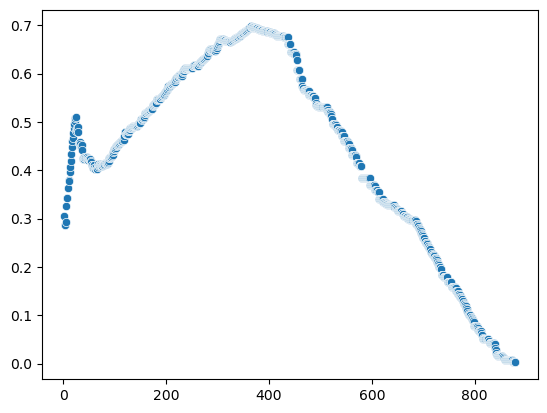

In [46]:
sns.scatterplot(x=scores.keys(), y=scores.values()) #365 is the optimal number of clusters
max(scores, key=scores.get)

In [48]:
agg = AgglomerativeClustering(n_clusters=365, affinity='euclidean', linkage='ward')
agg = agg.fit(pivotDF)

In [49]:
pivotDF["cluster"] = agg.labels_
pivotDF.reset_index(inplace=True)
pivotDF.head()

item_id,user_id,50,100,181,258,294,cluster
0,0,5.0,-1.0,-1.0,-1.0,-1.0,132
1,1,5.0,5.0,5.0,5.0,-1.0,142
2,2,5.0,5.0,-1.0,3.0,1.0,253
3,3,-1.0,-1.0,4.0,2.0,2.0,277
4,4,5.0,-1.0,-1.0,5.0,5.0,48


In [54]:
pivotDF.loc[pivotDF.loc[:,'user_id'] == 491]

item_id,user_id,50,100,181,258,294,cluster
461,491,-1.0,5.0,-1.0,4.0,2.0,20


In [55]:
pivotDF.loc[pivotDF.loc[:,'cluster'] == 20]

item_id,user_id,50,100,181,258,294,cluster
387,414,-1.0,5.0,-1.0,5.0,2.0,20
461,491,-1.0,5.0,-1.0,4.0,2.0,20


In [60]:
recomendDF = reviews.loc[reviews['user_id'].isin([414, 491])].reset_index(drop=True)
recomendDF.head()

,user_id,item_id,rating
0,414,100,5
1,414,264,3
2,414,294,2
3,414,678,1
4,414,310,4
